In [3]:
%matplotlib inline

import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import s3fs
import fsspec
import dask
from dask.distributed import performance_report, Client, progress


In [4]:
client = Client()
client

2022-10-10 20:41:06,511 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/b_/gxd85x_n4jv7sxtvcc1sv46c0000gp/T/dask-worker-space/worker-_tx0j227', purging
2022-10-10 20:41:06,528 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/b_/gxd85x_n4jv7sxtvcc1sv46c0000gp/T/dask-worker-space/worker-dsvm15sc', purging
2022-10-10 20:41:06,528 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/b_/gxd85x_n4jv7sxtvcc1sv46c0000gp/T/dask-worker-space/worker-xn1fonf1', purging
2022-10-10 20:41:06,528 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/b_/gxd85x_n4jv7sxtvcc1sv46c0000gp/T/dask-worker-space/worker-15mxqd0v', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59989,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:60071,Total threads: 2
Dashboard: http://127.0.0.1:60074/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:59996,


# Problem 1

### Create SST Dataset

In [5]:
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url2 = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    
    file_list.append(single_file)


In [6]:
file_list

['https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1979/e5.moda.an.sfc.128_034_sstk.ll025sc.1979010100_1979120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1980/e5.moda.an.sfc.128_034_sstk.ll025sc.1980010100_1980120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1981/e5.moda.an.sfc.128_034_sstk.ll025sc.1981010100_1981120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1982/e5.moda.an.sfc.128_034_sstk.ll025sc.1982010100_1982120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1983/e5.moda.an.sfc.128_034_sstk.ll025sc.1983010100_1983120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1984/e5.moda.an.sfc.128_034_sstk.ll025sc.1984010100_1984120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1985/e5.moda.an.sfc.128_034_sstk.ll025sc.1985010100_1985120100.nc',
 'https://rda.ucar.edu/thre

In [7]:
ds = xr.open_mfdataset(file_list, chunks={'time': '100MB'}).sel(latitude=slice(65, -65, 1),longitude=slice(120, 300, 1)).compute()

In [8]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 521, longitude: 721, time: 516)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) int32 1979010100 1979020100 ... 2021110100 2021120100
    SSTK       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper02 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon Nov 11 07:46:57 MST 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon Nov 11 07:46:58 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [9]:
gb = ds.SSTK.groupby('time.month')
gb

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [10]:
anom = gb - gb.mean(dim='time')

In [11]:
anom

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
array([[[            nan,             nan,             nan, ...,
         -8.17871094e-03, -1.33056641e-02, -1.83410645e-02],
        [            nan,             nan,             nan, ...,
         -1.33972168e-02, -2.06604004e-02, -2.74963379e-02],
        [            nan,             nan,             nan, ...,
         -1.77917480e-02, -2.50244141e-02, -3.21960449e-02],
        ...,
        [-3.00506592e-01, -3.01300049e-01, -3.02459717e-01, ...,
                     nan,             nan,             nan],
        [-8.54736328e-01, -8.40728760e-01, -8.27301025e-01, ...,
                     nan,             nan,             nan],
        [-8.32458496e-01, -8.32183838e-01, -8.46466064e-01, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
         -5.18798828e-04, -7.01904297e-04, -8.85009766e-04],
        [            nan,             nan,             nan, ...,
         -7.01904297e-04, -1.92260742e-03, -3.54003906e-03],
        [            nan,             nan,             nan, ...,
         -1.58691406e-03, -4.24194336e-03, -6.86645508e-03],
...
                     nan,             nan,             nan],
        [-6.92749023e-03, -8.08715820e-03, -9.15527344e-03, ...,
                     nan,             nan,             nan],
        [-8.54492188e-04, -1.40380859e-03, -1.40380859e-03, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
          9.37194824e-02,  6.34460449e-02,  3.24096680e-02],
        [            nan,             nan,             nan, ...,
          7.76062012e-02,  5.41687012e-02,  3.11279297e-02],
        [            nan,             nan,             nan, ...,
          7.62939453e-02,  5.80749512e-02,  4.01306152e-02],
        ...,
        [-1.10382080e-01, -8.47473145e-02, -6.00891113e-02, ...,
                     nan,             nan,             nan],
        [-3.03283691e-01, -2.89428711e-01, -2.75299072e-01, ...,
                     nan,             nan,             nan],
        [-1.43981934e-01, -1.37939453e-01, -1.40350342e-01, ...,
                     nan,             nan,             nan]]],
      dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

#### Mask data

In [16]:
mask_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'
mask = xr.open_dataset(mask_url).sel(latitude=slice(65, -65, 1),longitude=slice(120, 300, 1)).compute()

In [31]:
mask_drop = mask.squeeze('time')
mask_time = mask_drop.expand_dims(time=anom.time)

In [62]:
mask_SST = anom.where(mask_time.LSM==0., np.nan)

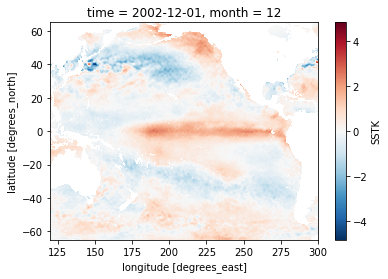

In [68]:
mask_SST.sel(time='2002-12-01', method='nearest').plot()

In [76]:
mask_SST

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
array([[[            nan,             nan,             nan, ...,
         -8.17871094e-03, -1.33056641e-02, -1.83410645e-02],
        [            nan,             nan,             nan, ...,
         -1.33972168e-02, -2.06604004e-02, -2.74963379e-02],
        [            nan,             nan,             nan, ...,
         -1.77917480e-02, -2.50244141e-02, -3.21960449e-02],
        ...,
        [-3.00506592e-01, -3.01300049e-01, -3.02459717e-01, ...,
                     nan,             nan,             nan],
        [-8.54736328e-01, -8.40728760e-01, -8.27301025e-01, ...,
                     nan,             nan,             nan],
        [-8.32458496e-01, -8.32183838e-01, -8.46466064e-01, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
         -5.18798828e-04, -7.01904297e-04, -8.85009766e-04],
        [            nan,             nan,             nan, ...,
         -7.01904297e-04, -1.92260742e-03, -3.54003906e-03],
        [            nan,             nan,             nan, ...,
         -1.58691406e-03, -4.24194336e-03, -6.86645508e-03],
...
                     nan,             nan,             nan],
        [-6.92749023e-03, -8.08715820e-03, -9.15527344e-03, ...,
                     nan,             nan,             nan],
        [-8.54492188e-04, -1.40380859e-03, -1.40380859e-03, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
          9.37194824e-02,  6.34460449e-02,  3.24096680e-02],
        [            nan,             nan,             nan, ...,
          7.76062012e-02,  5.41687012e-02,  3.11279297e-02],
        [            nan,             nan,             nan, ...,
          7.62939453e-02,  5.80749512e-02,  4.01306152e-02],
        ...,
        [-1.10382080e-01, -8.47473145e-02, -6.00891113e-02, ...,
                     nan,             nan,             nan],
        [-3.03283691e-01, -2.89428711e-01, -2.75299072e-01, ...,
                     nan,             nan,             nan],
        [-1.43981934e-01, -1.37939453e-01, -1.40350342e-01, ...,
                     nan,             nan,             nan]]],
      dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

### Create Precip Dataset

In [89]:
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
base_url2 = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    
    file_list.append(single_file)

In [90]:
file_list

['https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1979/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1979010100_1979120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1980/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1980010100_1980120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1981/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1981010100_1981120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1982/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1982010100_1982120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1983/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1983010100_1983120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1984/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1984010100_1984120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1985/e5.moda.fc.

In [91]:
ds_p = xr.open_mfdataset(file_list, chunks={'time': '100MB'}).sel(latitude=slice(65, -65, 1),longitude=slice(120, 300, 1)).compute()

In [92]:
ds_p

<xarray.Dataset>
Dimensions:    (latitude: 521, longitude: 721, time: 516)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) int32 1979010100 1979020100 ... 2021110100 2021120100
    TP         (time, latitude, longitude) float32 0.0002079 ... 0.0007496
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper02 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon Nov 11 08:45:33 MST 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon Nov 11 08:45:34 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [94]:
group_p = ds_p.TP.groupby('time.month')
group_p

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [95]:
precip_anom = group_p - group_p.mean(dim='time')

In [96]:
precip_anom

<xarray.DataArray 'TP' (time: 516, latitude: 521, longitude: 721)>
array([[[-1.5105758e-04, -1.4256322e-04, -1.3364747e-04, ...,
          1.4146538e-03,  1.3548607e-03,  1.2932711e-03],
        [-1.6753617e-04, -1.6219117e-04, -1.5434000e-04, ...,
          1.2891237e-03,  1.2950897e-03,  1.3049148e-03],
        [-1.7917989e-04, -1.7944601e-04, -1.8002267e-04, ...,
          1.1772333e-03,  1.1944881e-03,  1.2119426e-03],
        ...,
        [-8.8500977e-04, -8.7853370e-04, -8.7223493e-04, ...,
         -1.6561775e-03, -1.7499479e-03, -1.8333390e-03],
        [-8.6686772e-04, -8.5289532e-04, -8.3721511e-04, ...,
         -1.5539790e-03, -1.3889268e-03, -1.2241408e-03],
        [-7.2756479e-04, -7.0964464e-04, -6.9019408e-04, ...,
         -1.1482239e-03, -1.0370432e-03, -8.9820591e-04]],

       [[ 1.3395798e-04,  1.3455679e-04,  1.3537740e-04, ...,
          1.9991009e-03,  2.0877705e-03,  2.1731132e-03],
        [ 1.0836401e-04,  1.0878540e-04,  1.1093673e-04, ...,
          2.2057821e-03,  2.3874238e-03,  2.5889596e-03],
        [ 1.0182138e-04,  1.0060155e-04,  9.7784883e-05, ...,
          2.5264830e-03,  2.7894531e-03,  3.0510039e-03],
...
        [-6.1665021e-04, -6.3119933e-04, -6.4776663e-04, ...,
          2.3709675e-03,  1.9019148e-03,  1.4396047e-03],
        [-7.0126110e-04, -7.1410241e-04, -7.2694384e-04, ...,
          7.8332145e-04,  6.2915892e-04,  4.7280069e-04],
        [-7.1754016e-04, -7.2984921e-04, -7.4371067e-04, ...,
          1.4719856e-04,  8.5897278e-05, -2.3109955e-05]],

       [[-2.1998826e-04, -2.2391387e-04, -2.2790598e-04, ...,
          1.2422828e-03,  1.2700058e-03,  1.2982835e-03],
        [-2.2165166e-04, -2.2788381e-04, -2.3183157e-04, ...,
          1.2917408e-03,  1.2979507e-03,  1.3027635e-03],
        [-2.1765952e-04, -2.2843826e-04, -2.3937225e-04, ...,
          1.2558338e-03,  1.2549910e-03,  1.2540817e-03],
        ...,
        [ 3.6641059e-04,  3.0883518e-04,  2.5068328e-04, ...,
          1.3539956e-03,  4.6685687e-04, -3.9817020e-04],
        [ 1.8008915e-04,  1.1082587e-04,  4.1229767e-05, ...,
         -5.0688908e-04, -5.9498195e-04, -6.8340742e-04],
        [-3.6195270e-05, -1.0162173e-04, -1.6141497e-04, ...,
         -7.7150029e-04, -7.0188206e-04, -7.1501173e-04]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

#### Masked Data

In [97]:
mask_precip = precip_anom.where(mask_time.LSM==0., np.nan)

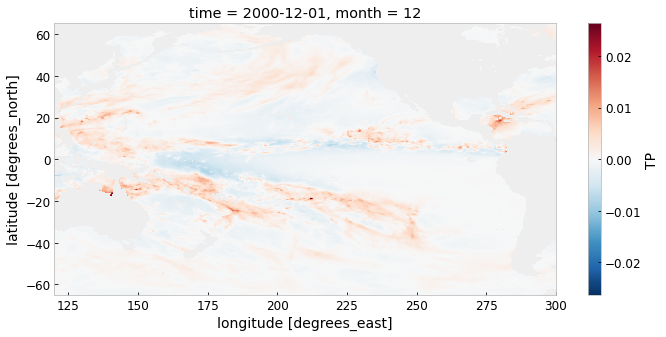

In [111]:
mask_precip.sel(time='2000-12-01', method='nearest').plot(size=5)

In [99]:
mask_precip

<xarray.DataArray 'TP' (time: 516, latitude: 521, longitude: 721)>
array([[[           nan,            nan,            nan, ...,
          1.4146538e-03,  1.3548607e-03,  1.2932711e-03],
        [           nan,            nan,            nan, ...,
          1.2891237e-03,  1.2950897e-03,  1.3049148e-03],
        [           nan,            nan,            nan, ...,
          1.1772333e-03,  1.1944881e-03,  1.2119426e-03],
        ...,
        [-8.8500977e-04, -8.7853370e-04, -8.7223493e-04, ...,
                    nan,            nan,            nan],
        [-8.6686772e-04, -8.5289532e-04, -8.3721511e-04, ...,
                    nan,            nan,            nan],
        [-7.2756479e-04, -7.0964464e-04, -6.9019408e-04, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
          1.9991009e-03,  2.0877705e-03,  2.1731132e-03],
        [           nan,            nan,            nan, ...,
          2.2057821e-03,  2.3874238e-03,  2.5889596e-03],
        [           nan,            nan,            nan, ...,
          2.5264830e-03,  2.7894531e-03,  3.0510039e-03],
...
        [-6.1665021e-04, -6.3119933e-04, -6.4776663e-04, ...,
                    nan,            nan,            nan],
        [-7.0126110e-04, -7.1410241e-04, -7.2694384e-04, ...,
                    nan,            nan,            nan],
        [-7.1754016e-04, -7.2984921e-04, -7.4371067e-04, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
          1.2422828e-03,  1.2700058e-03,  1.2982835e-03],
        [           nan,            nan,            nan, ...,
          1.2917408e-03,  1.2979507e-03,  1.3027635e-03],
        [           nan,            nan,            nan, ...,
          1.2558338e-03,  1.2549910e-03,  1.2540817e-03],
        ...,
        [ 3.6641059e-04,  3.0883518e-04,  2.5068328e-04, ...,
                    nan,            nan,            nan],
        [ 1.8008915e-04,  1.1082587e-04,  4.1229767e-05, ...,
                    nan,            nan,            nan],
        [-3.6195270e-05, -1.0162173e-04, -1.6141497e-04, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [112]:
anomalies = xr.DataArray()


# Problem 2

In [70]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.9.1


### Deseasonalize

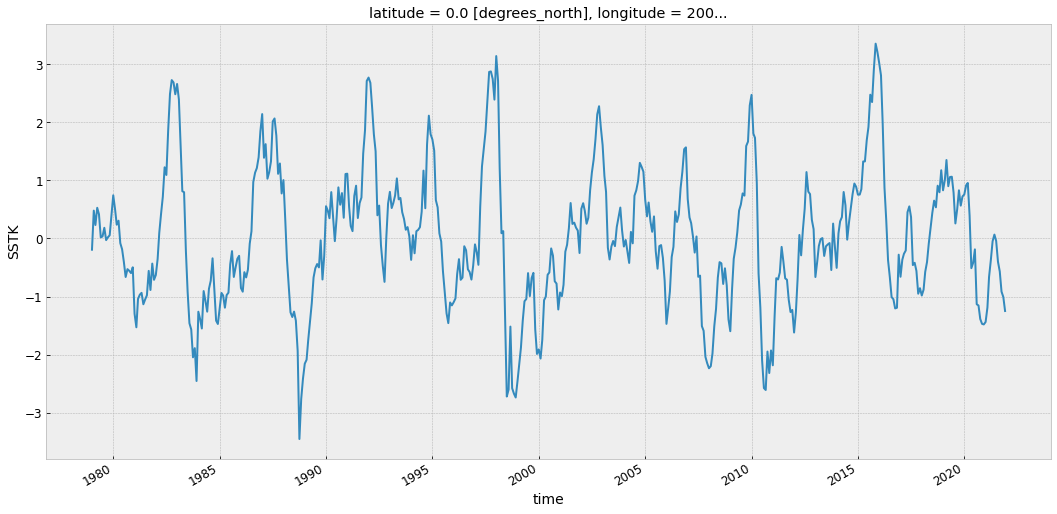

In [75]:
mask_SST.sel(latitude=0, longitude=200).plot()

In [124]:
#deseason = mask_SST.resample(time='AS').mean(dim='time') - mask_SST
deseason = (mask_SST*-1) + mask_SST.resample(time='AS').mean(dim='time')

In [125]:
deseason

<xarray.DataArray 'SSTK' (time: 43, latitude: 521, longitude: 721)>
array([[[           nan,            nan,            nan, ...,
         -2.2597758e-01, -2.3269399e-01, -2.3998007e-01],
        [           nan,            nan,            nan, ...,
         -2.5298563e-01, -2.4157462e-01, -2.2884879e-01],
        [           nan,            nan,            nan, ...,
         -2.7283478e-01, -2.5461069e-01, -2.3645273e-01],
        ...,
        [ 1.3474019e-01,  1.3316345e-01,  1.3195038e-01, ...,
                    nan,            nan,            nan],
        [ 6.8032330e-01,  6.6902667e-01,  6.5843964e-01, ...,
                    nan,            nan,            nan],
        [ 6.4600629e-01,  6.4825696e-01,  6.6456860e-01, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
         -5.8456421e-02, -3.3271790e-02, -8.2499180e-03],
        [           nan,            nan,            nan, ...,
          1.3656616e-02,  4.4843040e-02,  7.6123551e-02],
        [           nan,            nan,            nan, ...,
          3.4009296e-02,  6.6068009e-02,  9.7979233e-02],
...
        [-3.8877869e-01, -3.7619528e-01, -3.6332956e-01, ...,
                    nan,            nan,            nan],
        [-3.3522034e-01, -3.3235678e-01, -3.2886505e-01, ...,
                    nan,            nan,            nan],
        [-3.0858359e-01, -3.0161285e-01, -2.9042816e-01, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
          5.2982074e-01,  4.8721567e-01,  4.4420370e-01],
        [           nan,            nan,            nan, ...,
          5.1127625e-01,  4.8590341e-01,  4.5346323e-01],
        [           nan,            nan,            nan, ...,
          5.1112115e-01,  4.6139273e-01,  4.1078439e-01],
        ...,
        [ 4.5116678e-01,  2.9683939e-01,  1.4189911e-01, ...,
                    nan,            nan,            nan],
        [ 1.0221863e-01, -1.5523274e-02, -1.3450877e-01, ...,
                    nan,            nan,            nan],
        [-2.9383340e-01, -3.8956451e-01, -4.6325937e-01, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2021-01-01
    month      (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1

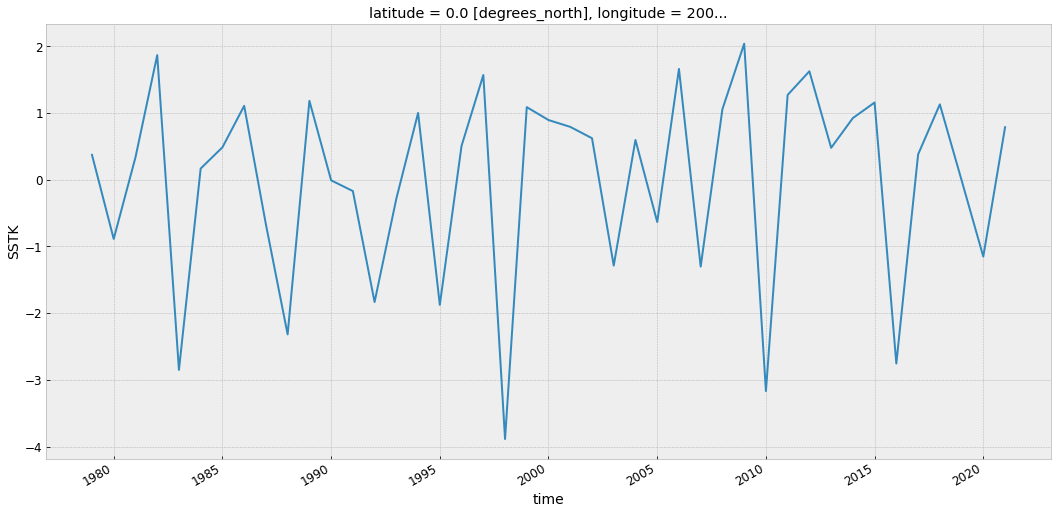

In [126]:
deseason.sel(latitude=0, longitude=200).plot()

In [85]:
data = deseason.sel(latitude=0, longitude=200)

In [30]:
client.close()

2022-10-10 18:06:45,775 - distributed.nanny - WARNING - Worker process still alive after 3.999995040893555 seconds, killing
2022-10-10 18:06:45,849 - distributed.nanny - WARNING - Worker process still alive after 3.9999982833862306 seconds, killing
2022-10-10 18:06:45,858 - distributed.nanny - WARNING - Worker process still alive after 3.999999237060547 seconds, killing
2022-10-10 18:06:45,869 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
